### Using Linear and Random Forest Regressors to Predict Book Ranks

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import time
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 300)
from textblob import TextBlob
from sklearn.linear_model import Ridge
from matplotlib import pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

/Users/jitsen/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/jitsen/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Read in Review Dataset

In [2]:
df = pd.read_csv('review_final.csv')

In [3]:
final_df = df[(~df['review_text'].isnull())]
final_df = final_df[(final_df['review_text'].apply(lambda x: len(x)>0))]

In [4]:
final_df['title'].nunique()

477

### Calculate Sentiment

In [5]:
final_df['sentiment'] = final_df['review_text'].apply(lambda x: TextBlob(x).polarity)

### Calculate length of review

In [6]:
final_df['review_length'] = final_df['review_text'].apply(lambda x: len(x))

In [7]:
final_df['list_date'] = pd.to_datetime(final_df['list_date']).apply(lambda x: x.timestamp())

In [8]:
filter_df = final_df[final_df['rank'] == final_df.groupby(['primary_isbn10'])['rank'].transform(max)]

In [9]:
len(filter_df)

1325

### Fit Regression Model and Get R^2 and Adjusted R^2

In [11]:
model_df = filter_df[['rank', 
                      'weeks_on_list',
                      'publisher',
                      'list_title',
                      'sentiment',
                      'review_length']]

df_dummy = pd.get_dummies(model_df, 
                          drop_first=False, 
                          columns=['publisher',
                                   'list_title'])

stats_model = Ridge(fit_intercept=True, 
                    normalize=True)
X = df_dummy.drop(labels=['rank'],
                  axis=1)
y = df_dummy['rank'] 
stats_model.fit(X, y)
df_dummy['pred_rank'] = stats_model.predict(X)
stats_model.score(X, y), 1 - (1-stats_model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

(0.4606378282726052, 0.36466591159513273)

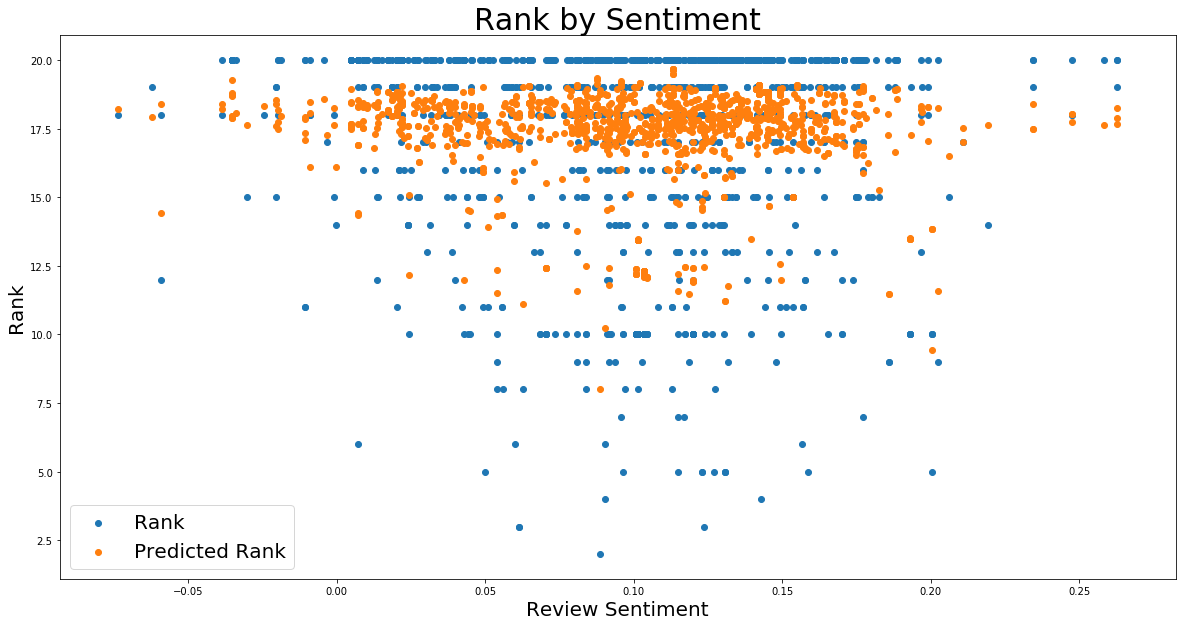

In [12]:
plt.figure(figsize = (20,10));
plt.scatter(x=df_dummy['sentiment'], y=df_dummy['rank'],label = 'Rank');
plt.scatter(x=df_dummy['sentiment'], y=df_dummy['pred_rank'], label = 'Predicted Rank')
plt.ylabel('Rank', fontsize = 20);
plt.xlabel('Review Sentiment', fontsize = 20);
plt.title('Rank by Sentiment', fontsize = 30);
plt.legend(fontsize = 20);

### Linear Regression with Cross Validation

(0.3098024370830027, 0.48938500440990845)
(0.37269439467388155, 0.44851268059578997)
(0.34299901126934307, 0.5283107208597269)
(0.3157634206268275, 0.4807635091358622)
(0.2721405750365159, 0.5047117954293339)
(0.3166682708158217, 0.49425879381663185)
(0.36122735164664266, 0.46923944561685016)
(0.29662989108907056, 0.519971492674829)
(0.3543238553063417, 0.4820611633851625)
(0.3171971285037837, 0.476345302702326)


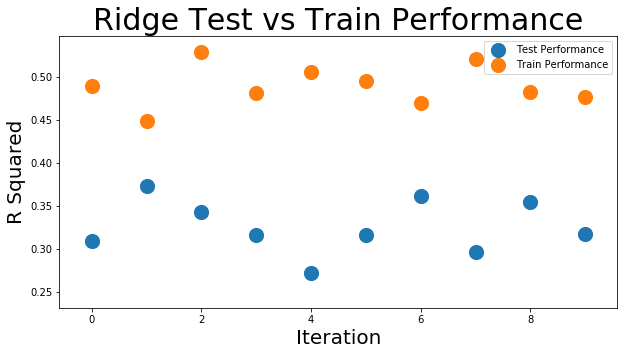

In [13]:
def lr_performance(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    lr = Ridge(fit_intercept=True, 
               normalize=True)
    lr.fit(X_train, y_train)
    return lr.score(X_test, y_test), lr.score(X_train, y_train)

def lr_test_train_iterations(X,y,z=10): 
    train_list = []
    test_list = []
    for i in range(z):
        result = lr_performance(X,y)
        print(result)
        train_list.append(result[1])
        test_list.append(result[0])
    plt.figure(figsize = (10,5));
    plt.scatter(x=[x for x in range(z)], 
            y=test_list,
            s=200,
            label = 'Test Performance')
    plt.scatter(x=[x for x in range(z)], 
             y=train_list,
             s=200,
             label = 'Train Performance')
    plt.ylabel('R Squared', fontsize = 20);
    plt.xlabel('Iteration', fontsize = 20);
    plt.title('Ridge Test vs Train Performance', fontsize = 30);
    plt.legend(fontsize = 10);

lr_test_train_iterations(X,y,10)

Clearly our model is very overfit, given the very poor performance of the test scores, compared with the train scores

### Get Top Coefficients

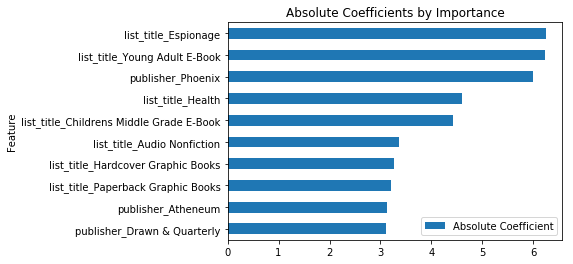

In [40]:
lr = Ridge(fit_intercept=True, 
           normalize=True)
lr.fit(X, y)

pd.DataFrame(sorted(zip(X.columns,[abs(x) for x in lr.coef_]),key = lambda x: x[1], reverse=True)[:10])\
            .rename(columns={0:'Feature',
                             1:'Absolute Coefficient'})\
            .set_index('Feature')[::-1]\
            .plot(kind='barh',
                  title='Absolute Coefficients by Importance')

### Random Forest Regresssion with Cross Validation

(0.508196603964649, 0.873561389771665)
(0.47942889244596215, 0.889135694928537)
(0.5182618733318762, 0.8678035359281185)
(0.5367554154444925, 0.9040218284658986)
(0.47998403116190613, 0.9011544434531005)
(0.4207607428210379, 0.9034596224462785)
(0.5507118021404463, 0.9031928775670732)
(0.4760091126075227, 0.9045112619210398)
(0.5118089200329137, 0.8830749764965634)
(0.5628335968590661, 0.8676664612898966)


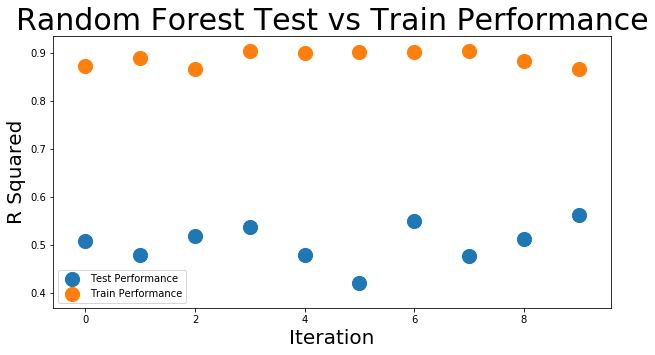

In [15]:
def rf_performance(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    rand_forest = RandomForestRegressor(n_estimators=5, 
                                        min_samples_split=2)
    rand_forest.fit(X_train, y_train)
    return rand_forest.score(X_test, y_test), rand_forest.score(X_train, y_train)

def rf_test_train_iterations(X,y,z=10): 
    train_list = []
    test_list = []
    for i in range(z):
        result = rf_performance(X,y)
        print(result)
        train_list.append(result[1])
        test_list.append(result[0])
    plt.figure(figsize = (10,5));
    plt.scatter(x=[x for x in range(z)], 
            y=test_list,
            s=200,
            label = 'Test Performance')
    plt.scatter(x=[x for x in range(z)], 
             y=train_list,
             s=200,
             label = 'Train Performance')
    plt.ylabel('R Squared', fontsize = 20);
    plt.xlabel('Iteration', fontsize = 20);
    plt.title('Random Forest Test vs Train Performance', fontsize = 30);
    plt.legend(fontsize = 10);
    
rf_test_train_iterations(X,y,10)

### Feature Importances

In [16]:
rand_forest = RandomForestRegressor(n_estimators=5, min_samples_split=2)
rand_forest.fit(X, y)
sorted(zip(X.columns,rand_forest.feature_importances_),key = lambda x: x[1], reverse=True)[:10]

[('review_length', 0.21599602469906215),
 ('weeks_on_list', 0.18200741060397813),
 ('sentiment', 0.06600718878294987),
 ('publisher_Houghton Mifflin Harcourt', 0.043834950901197225),
 ('list_title_Picture Books', 0.03467254981727961),
 ('list_title_Paperback Nonfiction', 0.03429518898633012),
 ('list_title_Trade Fiction Paperback', 0.031892008889207214),
 ('list_title_E-Book Nonfiction', 0.02621728082853659),
 ('list_title_Paperback Graphic Books', 0.025637707456186275),
 ('publisher_Random House Publishing', 0.018082397107143176)]

### Add Amazon Ranking Information

In [14]:
amazon_rank_df = pd.read_csv('https://raw.githubusercontent.com/jitsen-design/Data-607-Final-Project/master/data/masterrankings.csv',
                             usecols=[0,1,2,3,4]
)

### Merge Data with Original Dataframe

In [44]:
merge_df = pd.merge(amazon_rank_df,
             final_df,
             right_on='primary_isbn10',
             left_on='ASIN',
             how='left').dropna(subset=['sentiment'])

In [45]:
len(merge_df)

1600

We have only 38 unique samples, but let's run the models on htis set anyway!

In [20]:
len(merge_df['ASIN'].unique())

38

### Fit Regression Model and Get R^2 and Adjusted R^2

In [71]:
model_df2 = merge_df[['rank',
                      'GROUP',
                      'FORMAT',
                      'weeks_on_list',
                      'publisher',
                      'list_title',
                      'review_length',
                      'sentiment',
                      ]]

df_dummy2 = pd.get_dummies(model_df2, 
                          drop_first=False, 
                          columns=['publisher',
                                   'GROUP', 
                                   'FORMAT',
                                   'list_title'])

stats_model2 = Ridge(fit_intercept=True, normalize = True)
X2 = df_dummy2.drop(labels=['rank'],
                  axis=1)
y2 = df_dummy2['rank'] 
stats_model2.fit(X2, y2)
df_dummy2['pred_rank'] = stats_model2.predict(X2)
stats_model2.score(X2, y2), 1 - (1-stats_model2.score(X2, y2))*(len(y2)-1)/(len(y2)-X2.shape[1]-1)

(0.13383298260115095, 0.10123227720911121)

(0.11279919419170092, 0.15919721635912898)
(0.09351828578233812, 0.14735787984863802)
(0.10517671152400919, 0.15976051054028717)
(0.09512185756382253, 0.16785142354163218)
(0.09915951992472183, 0.1553744491833401)
(0.10017167531095883, 0.16278228295820932)
(0.11346288306454222, 0.12648123287394697)
(0.11069760776416115, 0.13276511379850653)
(0.09574229914787447, 0.15429157194894771)
(0.07884130682134283, 0.17940322828927255)


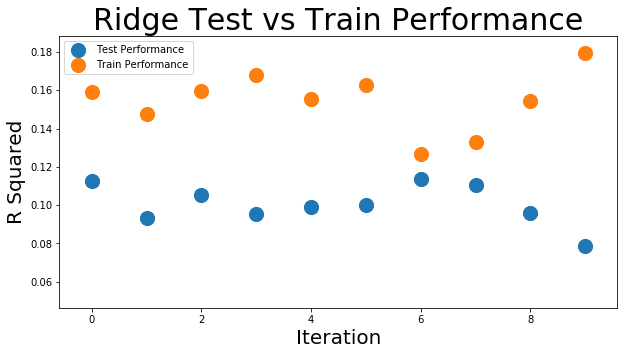

In [72]:
lr_test_train_iterations(X2,y2,10)

(0.6103208981249538, 0.8284768664525044)
(0.6210399967891679, 0.8062295081788012)
(0.6326681866292778, 0.7953732468118401)
(0.6764699876452459, 0.8027597922848267)
(0.6410535305741678, 0.8184116194816573)
(0.6337301085384488, 0.8137457238400305)
(0.6580992402046717, 0.806556442731974)
(0.6948106446672916, 0.797422590190306)
(0.5967151691689265, 0.8165671549545324)
(0.7130080678150688, 0.8063737221803442)


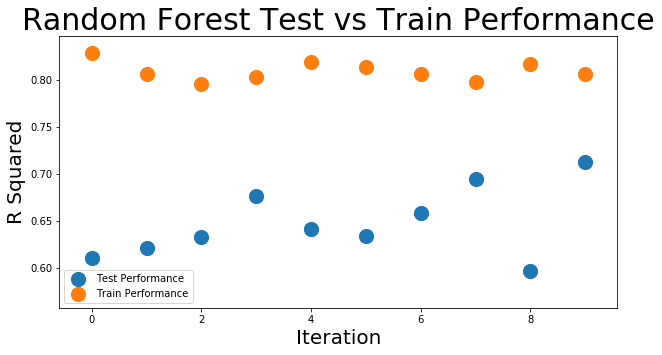

In [73]:
rf_test_train_iterations(X2,y2,10)

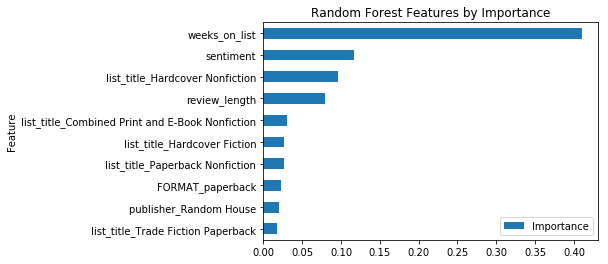

In [76]:
rand_forest2 = RandomForestRegressor(n_estimators=5, min_samples_split=2)
rand_forest2.fit(X2, y2)
pd.DataFrame(sorted(zip(X2.columns,rand_forest2.feature_importances_),key = lambda x: x[1], reverse=True)[:10])\
            .rename(columns={0:'Feature',
                             1:'Importance'})\
            .set_index('Feature')[::-1]\
            .plot(kind='barh',
                  title='Random Forest Features by Importance');

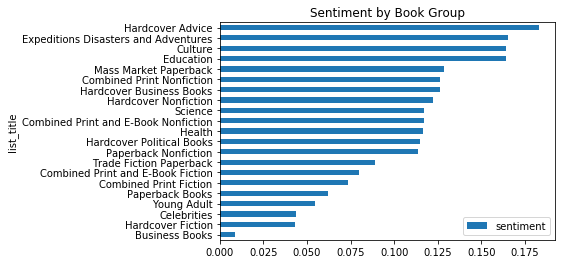

In [75]:
merge_df.groupby('list_title').agg({'sentiment':'mean'})\
                              .sort_values(by='sentiment')\
                              .plot(kind='barh',
                                    title='Sentiment by Book Group'
                                    
                              );